#  Aspects of Electro-Acoustics

## Miniature loudspeakers: simulations with experimental validations 

Stephane Dedieu, Jan. 2023


These programs were developped for clients in a consulting practice, back in 2006-2009. <br> 
Initially all codes were open source Scilab scripts. <br>
We coded them "as is" in Python. 



### Miniature speakers

<span style="color:#4169E1"> The following high quality miniature-speakers were designed and manufactured by NXP Semiconductors in the late 2000s. Their applications were mainly: loudspeakers and receivers for smartphones. 

<img src="Micro_Speakers.png" width="800" height="400">

|       |Re [Ohm]| Bl [Tm]|Mms [kg]|Cms [m/N]|Rms [kg/s] |Sd [m^2]| SPL [dBSPL/W/m]|Fres [Hz]|Qms|Qes|Qts|Vas [m^3]|         
| ---   | ---    | ---    | ---    | ---     | ---       | ---    | ---            | ---     |---|---|---|---      |
|<b>Grace</b> |7.25|0.582|43.1 10<sup>-6</sup>| 648.3 10<sup>-6</sup>|46.7 10<sup>-3</sup>|  110.0 10<sup>-6</sup>  |74.41| 950.0 |5.48 |5.82|2.80|1.11 10<sup>-6</sup>|
| <b>11 x 15 mm</b> |7.53|0.836|74.8 10<sup>-6</sup>| 13.4 10<sup>-3</sup>|7.64 10<sup>-2</sup>|  115.0 10<sup>-6</sup>  |73.14| 449.0 |3.06 |0.64|0.53|3.11 10<sup>-6</sup>|
| <b>Tiny</b> |7.11|0.411|33.0 10<sup>-6</sup>| 1.96 10<sup>-3</sup>|48.6 10<sup>-3</sup>|  65.0 10<sup>-6</sup>  |69.3| 630.0 |2.69 |5.48|1.80|1.17 10<sup>-6</sup>|

<span style="color:#4169E1">  In the following simulations we use the 11x15 mm speaker for: <br>

    
- <span style="color:#4169E1"> its low f0= 449 Hz  
- <span style="color:#4169E1">its overall quality for designing miniature loudspeaker solutions.  
    
<span style="color:#4169E1"> Simulations:
    
- <span style="color:#4169E1"> 11x15 mm speaker in a sealed enclosure
- <span style="color:#4169E1"> 11x15 mm speaker in a ported enclosure (bass-reflex)
- <span style="color:#4169E1"> subwoofer
    
<span style="color:#4169E1"> <b>Prototypes:</b>
   
| <img src="Prototype_002.png" width="150">     |   <img src="Measurement_025cm.png" width="300"> |
| --- | ---  |
| <center> 11x15mm speaker and 7 cm ported box</center>    | <center>Validation - Test Set-up </center>     |    
    
    
<span style="color:#4169E1"> <b>Important remark:</b> <br>
In practise, the NXP 11x15 mm is supposed to work with low compliance sealed enclosures (small enclosures): volume 1 - 2 cc. <br> Large ported enclosure, here 7-cc, will induce strong distortion close to 1st speaker resonance.  
The prototypes were built for validation purposes.    
    
    
<span style="color:#4169E1"> <b> References:</b> <br>
[1] Leo Beranek “Acoustics”, 1993 Edition

###  BASS-REFLEX ENCLOSURE 

Impedance model of a speaker in a Bass-Reflex enclosure
After Beranek [1]. 


| <img src="BassReflexProto.png" width="300">     |   <img src="EQCircuit_BassReflex.png" width="500"> |
| --- | ---  |
| <center>Bass-Reflex Enclosure <br> Volume = 7 cc, port: l=50 mm, diam: 4mm.</center>| <center>Equivalent Circuit </center>     |

Sound pressure level - Far field

<img src="SoundFarField.png" width="250">  

In [1]:
import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [2]:
import scipy
from scipy import signal
from skimage import util
from scipy.signal import general_gaussian
from scipy.signal import savgol_filter
from scipy.fftpack import fft, fftshift
import cmath
import math

In [3]:
def parallel(z1,z2) :
    z = (z1*z2)/(z1+z2)
    return z

def series(z1,z2) :
    z = z1 + z2    
    return z

In [4]:
#------------------
#Acoustic constants
#------------------
ro = 1.21  # Air density (kg/m3) 
cel = 340  # Sound celerity m/s
afreq= np.arange(100, 10000, 1, dtype=int) # frequency range for simluation
w = (2*np.pi)*afreq     # circular frequency (rad/s)
k = w/cel               # wavenumber rad/m              

In [5]:
#============  Thiele Small Parameters (Electro-Mechanical Parameters) ==========================
#------- T-S 11x15 mm  NXP  ---------
f0 = 449               # 1st Resonance Frequency - free air (Hz)
w0 = (2*np.pi)*f0      # circular frequency (rad/s)
Re = 7.53              # Voice Coil DC resistance (Ohms)
Sd = 1.15e-04          # Diaphragm Area (m2)
Vas = 3.11e-06         # Equivalent volume (m3) - linked to suspension compliance
ksv = ((ro*(cel**2))*(Sd**2))/Vas # Speaker suspension stiffness  (N/m)
#-----------------------------------------------
Mmd =  7.48e-05        # Mass of speaker cone + voice coil  (kg)            
Bl = 0.836             # Force factor Bl(Tesla.m) 
# B= Magnetic flux density in air gap, l= length of voice coil wire 
# force on voice coil= Bl*i     (i=current)
Levc = 0 ; # Voice coil inductance - not provided by manufacturer   
#-----------------------------------------------                            
Qms = 3.06;  # Mechanical Q at f0
Qes = 0.64;  # Electrical Q at f0
Qts = 0.53;  # Total quality factor at f0:   Qts=Qms*Qes/(Qms+Qes) 
#Rm = (((2*np.pi)*f0)*Mmd)/Qms
Rm=7.64e-02;
#====================
Ze = Re+(Levc*1j)*w;
# Voice coil Impedance (replaces Re) Added 14 Septembre 2007
Re=Ze

In [6]:
#=================================================================================================
#              Sound Pressure radiated by the speaker in an infinite Baffle 
#              FOR VALIDATIONS PURPOSES ONLY (to be compared with TangBand measurement 1W/1meter)
#=================================================================================================
# 
rr =   0.5;            # Computation at 0.5 m
rrport=0.51;            
Em =   0.0707;         # Input voltage (V) ~ Sweep sine
#
#=============================================================================
#           SPEAKER BASS REFLEX  Enclosure Parameters + Electrical Parameters          |
#=============================================================================
Vbcc= 6;                            # Box/Enclosure volume (cm3)
Vb=Vbcc*1e-06;                      # Box/Enclosure volume (m3)          
#
kb = ((ro*(cel**2))*(Sd**2))/Vb;    # Box/Enclosure "stiffness" N.m  
Cmb=1/kb;                           # Box/Enclosure Compliance 1/(N.m). 
#-----------------------------
#Ma = Air Added Mass enclosure
#-----------------------------
a = np.sqrt(Sd/np.pi);              # diaphragm radius 
Ma1 = (((8*ro)*Sd)*a)/(3*np.pi);    # Added air mass
M = Mmd+Ma1;
#-----------------------------
# Speaker suspension Compliance and Stiffness
#-----------------------------
Cas = Vas/(ro*(cel**2))    # Acoustical compliance
Cms = Cas/(Sd**2);         # mechanical compliance
ks=1/Cms;             
ksealed = ks+kb;
#==================================
#                 Speaker + Enclosure compliance (or stiffness= 1/compliance)
#==================================
w0s = np.sqrt(ksealed/M);                      # Speaker f0s in sealed box
f0s = w0s/(2*np.pi);                         
Qtsenc = np.sqrt(ksealed*M)/(Rm+(Bl**2)/Re);   # Quality factor total, speaker in box
#=====================================
#                 PORT CHARACTERISTICS:  lenth= 50 mm, diameter= 4 mm
#=====================================
aport=0.002   # radius tube (m)
lport=0.05    # length tube (m)
#-----
mu=1.56e-5
nu=1.86e-5 
Sport=np.pi*(aport)**2;
Mport=ro*(lport+0.85*aport+0.61*aport)/(np.pi*aport**2);
#Mport=ro*(lport+1.7*aport)/(np.pi*aport**2);                             #  Beranek p 241 
Mp=Mport*Sd**2;
#===========   Enclosure Volume Correction (remove the port volume).
Sport2=np.pi*(aport+0.001)**2;                   #  Volume of air removed from initial enclosure volume
Vport=Sport2*lport;
VBr=Vb-Vport;                                                        #  Volume enclosure - volume of the port
#VBr=Vb;                                                             #  in case of EXTERNAL PORT
#----
kBr = ((ro*(cel**2))*(Sd**2))/VBr;
CBr=1/kBr;
#-------------
kport = ks+kBr;
w0br = np.sqrt(kport/M);
#===================== Damping - Port ===============================
#   Model n. 1
#   VECTOR !   5.54 p 137  Beranek  if a>0.01*sqrt(f) a<10/f  
#   Note: here a <.01*sqrt(f) adjustement is necessary ===>  THIS MODEL WILL UNDERESTIMATE PORT DAMPING 
#--------------------------------------------------------------------
Rport=ro*((2*mu*w)**0.5)*(lport/aport+2)/(np.pi*aport**2);  # 
#--------------------------------------------------------------------
#   Model n. 2
#   scalar:  if a<0.002/sqrt(f)
#   Note: here a> 0.002/sqrt(f)    ===>  THIS MODEL WILL SIGNIFICANTLY OVERESTIMATE PORT DAMPING 
#--------------------------------------------------------------------
#Rport=ro*cel/(2*np.pi*aport**2);    # if a<0.002/sqrt(f)      
#--------------------------------------------------------------------
#  The good model for port damping (resistor) is closer to model 1. But adjustment maybe necessary. 
#  See experimental validation.  
#-------------------------------------------------------------------- 
Rp=Rport*Sd**2;
#------
RAR2=(ro*cel*w**2)/(np.pi*(w**2*aport**2 + 2*cel**2))*Sd**2     #     Additional port damping (loss through acoustic radiation)
MAR2=(ro*cel*8*w)/(np.pi**2*a*(4*w**2*aport**2 + 3*cel**2))     #     Port added acoustic mass 
#--------
Rs=0;                               #     No leak in the cavity
#Rp=Rp+RAR2;                        #     Port damping   
Rp=1.5*Rp                             #     ajustment 2 * Rp 

In [7]:
#=================================================================================================     
#           Sound Pressure radiated by the speaker in an enclosure
#       zspeaker=  M*(i.*w) +  (Rm+ Bl**2/Re)+ ( 1 ./(Cms*(i.*w)));
#======================================================================
pg=Em*Bl*Sd**2/(Sd*Re);              #  Force on speaker cone - Newtons
#
zel2=Bl**2/(Re*Sd**2);               #  Electrical impedance
#
zarport=(RAR2 + MAR2*(1j*w))*Sd**2;  #  Port impedance (acoustics)
#
zspeaker=  M*(1j*w) + Rm + ( 1/(Cms*(1j*w)))+ zel2*Sd**2;  # Speaker impedance (mechanical)
#
zcavity=( Rs   +  1/(Cmb*(1j*w)));           # Sealed enclosure impedance  Rs effect of a leak in the cavity  Rs=0
#
zc1=( Rs  + 1  /(CBr*(1j*w)));               # ported enclosure impedance
#
zp1= Mp*(1j*w)  + Rp + zarport;              # Port impedance (mech + acoustics)
#
#
Z1=parallel(zc1,zp1);                        # ported enclosure + Port impedance
#
Ztotal=zspeaker+Z1;                          # ported enclosure Total impedance
Zclosed=series(zspeaker,zcavity);            # sealed enclosure Total impedance
#
#====  Volume velocity 
Uclosed=pg/Zclosed;                         # volume velocity speaker + sealed enclosure
#------
Ud=pg/Ztotal;                               # volume velocity speaker + ported enclosure 
Up1=Ud/(1+zp1/zc1);                         # volume velocity port 
#==== radiated sound pressure  
puclose=(ro/(4*np.pi*rr))*np.exp(-(1j*k)*rr  )*1j*w*Uclosed  # Sound pressure radiated by speaker in sealed enclosure
#----
pud=(ro/(4*np.pi*rr))*np.exp(-(1j*k)*rr  )*1j*w*(Ud)         # Sound pressure radiated by speaker in ported enclosure
pup1=(ro/(4*np.pi*rrport))*np.exp(-(1j*k)*rr  )*1j*w*(Up1);  # Sound pressure radiated by port ! 
#==============   total pressure, radiated by speaker + port. Port being out of phase with speaker
puu=pud-pup1

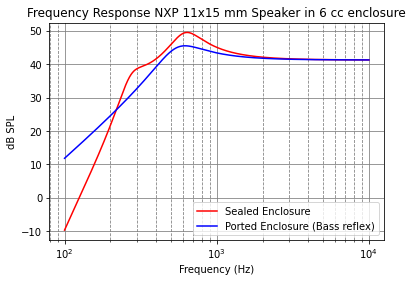

In [8]:
plt.semilogx(afreq,20*np.log10(abs(puu)/0.00002),'r')
plt.semilogx(afreq,20*np.log10(abs(puclose)/0.00002),'b')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

plt.xlabel('Frequency (Hz)');
plt.ylabel('dB SPL');
plt.legend(['Sealed Enclosure', 'Ported Enclosure (Bass reflex)']);
plt.title('Frequency Response NXP 11x15 mm Speaker in '+str(Vbcc)+' cc enclosure');

#### VALIDATION

<span style="color:#4169E1"> Recordings were performed in an anechoic chamber - NRC Ottawa. (in May 2009)

In [9]:
import librosa
y1,fs =  librosa.load("11x15mmSpeaker_Sealed.wav", sr=44100)
#y2,fs =  librosa.load("11x15mmSpeaker_BassReflex.wav", sr=44100)
y2,fs =  librosa.load("11x15mmSpeaker_BassReflex50mmx4mm.wav", sr=44100)

In [10]:
#  TEST FREQUENCY RESPONSE - Hz 

In [11]:
NFFT = 1024*8 

In [12]:
spectrum_F1= scipy.signal.welch(y1, fs=44100, window='hann', 
                   nperseg=NFFT, noverlap=NFFT//4, nfft=NFFT, 
                   detrend='constant', return_onesided=True, 
                   scaling='density', axis=-1, average='mean')

spectrum_F2= scipy.signal.welch(y2, fs=44100, window='hann', 
                   nperseg=NFFT, noverlap=NFFT//4, nfft=NFFT, 
                   detrend='constant', return_onesided=True, 
                   scaling='density', axis=-1, average='mean')

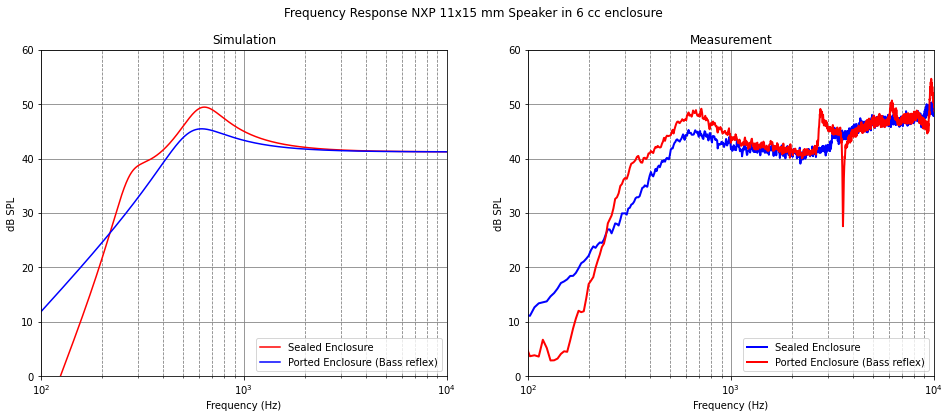

In [13]:
fig, axs = plt.subplots(1,2,figsize=(16,6))
fig.suptitle('Frequency Response NXP 11x15 mm Speaker in '+str(Vbcc)+' cc enclosure')

axs[0].semilogx(afreq,20*np.log10(abs(puu)/0.00002),'r')
axs[0].semilogx(afreq,20*np.log10(abs(puclose)/0.00002),'b')

axs[0].grid(b=True, which='major', color='grey', linestyle='-')
axs[0].grid(b=True, which='minor', color='grey', linestyle='--')
axs[0].set_xlim(100,10000)
axs[0].set_ylim(0,60)
axs[0].set_xlabel('Frequency (Hz)');
axs[0].set_ylabel('dB SPL');
axs[0].legend(['Sealed Enclosure', 'Ported Enclosure (Bass reflex)'],loc=4);
axs[0].set_title('Simulation');


axs[1].semilogx(spectrum_F1[0], 10*np.log10(spectrum_F1[1])+118  ,'b', linewidth=2)
axs[1].semilogx(spectrum_F2[0], 10*np.log10(spectrum_F2[1])+118, 'r', linewidth=2)

#-----------------
axs[1].grid(b=True, which='major', color='grey', linestyle='-')
axs[1].grid(b=True, which='minor', color='grey', linestyle='--')
axs[1].set_xlim(100,10000)
axs[1].set_ylim(0,60)
axs[1].set_xlabel('Frequency (Hz)');
axs[1].set_ylabel('dB SPL');
axs[1].legend(['Sealed Enclosure', 'Ported Enclosure (Bass reflex)'],loc=4);
axs[1].set_title('Measurement');

<span style="color:#4169E1">
    
- Input voltage had to be adjusted, as the measurement input voltage is not available.  
- The free air f0 of the speaker we measured is higher than f0=449 Hz of the simulation. There is a slight shift to the right. 
- We corrected the "resistance" of the port for perfect match of the port resonance (~300 Hz) damping. Correction factor: 1.5 
- Overall the simulation with the sealed enclosure and bass-reflex enclosure are satisfying. 

- we can see peaks and notches on the measured bass-reflex graph.
      - peak at 2.6 Khz could be linked to a half wavelength resonance in the enclosure, that leaked outside.
      - peak at 5.2 kHz could be linked to the activation of a quarter wavelength by the speaker.
      - notch at 3400 Hz linked to a resonance of the port: c/2L.
      
<span style="color:#4169E1"> These resonance are not reflected in the model. They could be introduced under the form of resonant RLC circuits in parallel with the enclosure model.    

###   BAND PASS ACOUSTIC FILTER - "SUBWOOFER"

<span style="color:#4169E1"> Impedance model of a speaker in a Subwoofer (Bass-Pass) enclosure
After Beranek [1]. The front resonator acts as a low-pass filter. 

| <img src="SubWooferProto.png" width="300">     |   <img src="BandPassAcousticFilter.png" width="500"> |
| --- | ---  |
| <center>Subwoofer: Band-Pass enclosure<br> Front volume: 4 cc, port: l=20 mm, diam: 4mm <br> Volume = 7 cc, port: l=50 mm, diam: 4mm. </center>    | <center>Equivalent Circuit</center>     |

In [14]:
#=================================================================================================     
#           Sound Pressure radiated by the speaker in an enclosure
#       zspeaker=  M*(i.*w) +  (Rm+ Bl**2/Re)+ ( 1 ./(Cms*(i.*w)));
#======================================================================
pg=Em*Bl*Sd**2/(Sd*Re);              #  Force on speaker cone - Newtons
#
zel2=Bl**2/(Re*Sd**2);               #  Electrical impedance
#
zarport=(RAR2 + MAR2*(1j*w))*Sd**2;  #  Port impedance (acoustics)
#
zspeaker=  M*(1j*w) + Rm + ( 1/(Cms*(1j*w)))+ zel2*Sd**2;  # Speaker impedance (mechanical)
#
zcavity=( Rs   +  1/(Cmb*(1j*w)));           # Sealed enclosure impedance  Rs effect of a leak in the cavity  Rs=0
#
zc1=( Rs  + 1  /(CBr*(1j*w)));               # ported enclosure impedance
#
zp1= Mp*(1j*w)  + Rp + zarport;              # Port impedance (mech + acoustics)
#
#
Z1=parallel(zc1,zp1);                        # ported enclosure + Port impedance
#
Ztotal=zspeaker+Z1;                          # ported enclosure Total impedance
Zclosed=series(zspeaker,zcavity);            # sealed enclosure Total impedance
#
#====  Volume velocity 
Uclosed=pg/Zclosed;                         # volume velocity speaker + sealed enclosure
#------
Ud=pg/Ztotal;                               # volume velocity speaker + ported enclosure 
Up1=Ud/(1+zp1/zc1);                         # volume velocity port 
#==== radiated sound pressure  
puclose=(ro/(4*np.pi*rr))*np.exp(-(1j*k)*rr  )*1j*w*Uclosed  # Sound pressure radiated by speaker in sealed enclosure
#----
pud=(ro/(4*np.pi*rr))*np.exp(-(1j*k)*rr  )*1j*w*(Ud)         # Sound pressure radiated by speaker in ported enclosure
pup1=(ro/(4*np.pi*rrport))*np.exp(-(1j*k)*rr  )*1j*w*(Up1);  # Sound pressure radiated by port ! 
#==============   total pressure, radiated by speaker + port. Port being out of phase with speaker
puu=pud-pup1

In [15]:
#=================================================================================================
#              Sound Pressure radiated by the speaker in an infinite Baffle 
#              FOR VALIDATIONS PURPOSES ONLY (to be compared with TangBand measurement 1W/1meter)
#=================================================================================================
# 
rr =   0.5;            # Computation at 0.5 m
rrport=0.51;            
Em =   0.0707;         # Input voltage (V) ~ Sweep sine
#
pbaffle = (((((Em*Bl)*ro)*Sd)/((((2*np.pi)*Re)*Mmd)*rr))*((w/w0)**2)) /(1+(1j *w) /(Qts*w0)-(w /w0)**2);
#--------------------------
#  volume velocity  q=Sd*ud
#--------------------------
ud = ((Em*Bl) /Ze) /((Bl**2) /Ze+(Mmd*1j) *w+ksv /(1j *w));
#
pdirect = (((((1j*ro) *w) *ud)*Sd) *np.exp(-(1j *k)*rr))/((2*np.pi)*rr);


#======================================================================
#           SPEAKER BASS REFLEX  Enclosure Parameters + Electrical Parameters          |
#======================================================================
Vbcc= 7;    # Enclosure volume (cm3)
Vb=Vbcc*1e-06;
#
kb = ((ro*(cel**2))*(Sd**2))/Vb;    # Enclosure "stiffness" N.m    
#-----------------------------
#Ma = Air Added Mass enclosure
#-----------------------------
a = np.sqrt(Sd/np.pi);   # diaphragm radius 
Ma1 = (((8*ro)*Sd)*a)/(3*np.pi);
M = Mmd+Ma1;
#-----------------------------
# Speaker suspension Stiffness
#-----------------------------

Cas = Vas/(ro*(cel**2));
Cms = Cas/(Sd**2);
ks=1/Cms;
#
ksealed = ks+kb;
#==================================
# Speaker + Enclosure stiffness
#==================================
w0s = np.sqrt(ksealed/M);         # Speaker f0 in the sealed enclosure
f0s = w0s/(2*np.pi);
Qtsenc = np.sqrt(ksealed*M)/(Rm+(Bl**2)/Re);
Cmb=1/kb;
#=====================================
#                 PORT CHARACTERISTICS
#=====================================
aport=0.002;
lport=0.05;
#-----
mu=1.56e-5;
nu=1.86e-5;
Sport=np.pi*(aport)**2;
Mport=ro*(lport+0.85*aport+0.61*aport)/(np.pi*aport**2);
Mport=ro*(lport+1.7*aport)/(np.pi*aport**2);                 #       Beranek p 241 
Mp=Mport*Sd**2;
#-----------------------------------------
Vport=Sport*lport;                                        #       Volume of the port
VBr=Vb-Vport;
#VBr=Vb;                                                  #  EXTERNAL PORT
#----
kBr = ((ro*(cel**2))*(Sd**2))/VBr;
CBr=1/kBr;
#-------------
kport = ks+kBr;
w0br = np.sqrt(kport/M);
#==========================================================
Rport=ro*((2*mu*w)**0.5)*(lport/aport+2)/(np.pi*aport**2);  # 
#   VECTOR !   5.54 p 137  Beranek  if a>0.01*np.sqrt(f) a<10/f    here a <.01*np.sqrt(f)
#-----------------
#Rport=ro*cel/(2*np.pi*aport**2);    # if a<0.002/np.sqrt(f)
Rp=Rport*Sd**2;
Sport=(np.pi*aport**2);
#-------
gam=7/5; #   Air   6.1.3 - 6.1.4   Morse Ungard
Ra=(2*(0.0021+0.0025*(gam-1))*ro/aport**3)*afreq**(0.5);    # Morse Ingard 9.1.12
#Rp=Ra*(lport+0.85*aport+0.61*aport)*Sd**2;

#=== SLIT ================================================
#    lslit=0.002 ;   #      depth 5mmm
#    tslit=0.0005 ;  #      thickness
#    wslit=0.02 ;    #      length
#    Rslit= 12*nu*lslit/(tslit**3*wslit);
#    Rs=Rslit*Sd**2;  
#=========================================================
RAR2=(1/(2*np.pi)**2)*0.01076*w**2;
#RAR2=0.0796*w**2*ro/cel;     # page 125  ACOUSTIC impedance end of long
#tube
Ra2=RAR2*Sd**2;   
Ra2=0;                 #     No additional port damnp.ping
Rs=0;                  #     No leak in the cavity
Rp=Rp + Ra2;                 #     Port damnp.ping 

#=================================================================================================

#======================================================================
#           FRONT RESONATOR FOR SUBWOOFER DESIGN         |
#======================================================================
Vrcc= 4;    # Enclosure volume (cm3)
Vr=Vrcc*1e-06;
#-----------------------------
#Ma = Air Aded Mass enclosure
#-----------------------------
a = np.sqrt(Sd/np.pi);   # diaphragm radius 
Ma2 = (((8*ro)*Sd)*a)/(3*np.pi);
M = Mmd+Ma1+Ma2;
#=====================================
#                 RESONATOR PORT CHARACTERISTICS
#=====================================
arp=0.002;
lrp=0.015;
#-----
Srp=np.pi*(arp)**2;
Mrp=ro*(lrp+0.85*arp+0.61*arp)/(np.pi*arp**2);
#Mrp=ro*(lrp+1.7*arp)/(np.pi*arp**2);                 #       Beranek p 241 
Mpr=Mrp*Sd**2;
#-----------------------------------------
Vrp=Srp*lrp;                                        #       Volume of the port
Vr=Vr-Vrp;
#----
krr = ((ro*(cel**2))*(Sd**2))/Vr;
Cr=1/krr;
#-------------
Rrp=ro*((2*mu*w)**0.5)*(lrp/arp+2)/(np.pi*arp**2);  # 
#   VECTOR !   5.54 p 137  Beranek  if a>0.01*np.sqrt(f) a<10/f    here a <.01*np.sqrt(f)
#-----------------
#Rport=ro*cel/(2*np.pi*aport**2);    # if a<0.002/np.sqrt(f)
RAR2=(ro*cel*w**2)/(np.pi*(w**2*arp**2 + 2*cel**2));
RAR2=(1/(2*np.pi)**2)*0.01076*w**2;
#MAR2=(ro*cel*8*w*cel)/(np.pi**2*a*(4*w**2*aport**2 + 3*cel**2));
Ra2=1*RAR2*Sd**2;  
Rr=Rrp*Sd**2;
Rr=Rr+Ra2;   
Rr=Rport*Sd**2;    
#=============  Sound Pressure radiated by the speaker in an enclosurezspeaker=  M*(i*w) +  (Rm+ Bl**2/Re)+ ( 1 /(Cms*(i*w)));
#
Sd=1*Sd;                                      #  Effective  surface 

pg=Em*Bl/(Sd*Re);          #  Newtons/m2

zel1=Levc*Sd**2;
zel2=Bl**2/(Re*Sd**2)
zelec=parallel(zel1,zel2);
#
zspeaker=  M*(1j*w) + Rm +Bl**2/Re + ( 1 /(Cms*(1j*w))); # + zelec;
#
zcavity=( Rs   +  1  /(Cmb*(1j*w)));           #   Rs effect of a leak in the cavity
#
zc1=( Rs  + 1  /(CBr*(1j*w)));
zp1= Mp*(1j*w)  + Rp ;
#
zp2= Mpr*(1j*w) + Rr ; 
zc2=(Rs+ 1 /(Cr*(1j*w)));
#
Z1=parallel(zc1,zp1);
Z2=parallel(zc2,zp2);
#
Ztotal=zspeaker+Z1+Z2;
Zclosed=series(zspeaker,zcavity);  


Ud=pg/Ztotal;


Uclosed=pg/Zclosed;

Up1= Ud/ (1+zp1/zc1);
Up2= Ud/ (1+zp2/zc2);


pud=(ro*Sd**2/(4*np.pi*rr))*np.exp(-(1j *k)*rr  )*1j*w*Ud; 

puclose=(ro*Sd**2/(4*np.pi*rr))*np.exp(-(1j *k)*rr  )*1j*w*Uclosed; 

pup1=(ro*Sd**2/(4*np.pi*rr))*np.exp(-(1j *k)*rr  )*1j*w*Up1; 
pup2=(ro*Sd**2/(4*np.pi*rr))*np.exp(-(1j *k)*rr  )*1j*w*Up2; 

puu=pup2-pup1;  

####  VALIDATION
Importing measurements.  (recordings)

In [16]:
y1,fs =  librosa.load("11x15mmSpeaker_Sealed.wav", sr=44100)
#y2,fs =  librosa.load("11x15mmSpeaker_BassReflex.wav", sr=44100)
y2,fs =  librosa.load("Subwoofer_003.wav", sr=44100)

In [17]:
spectrum_FF1= scipy.signal.welch(y1, fs=44100, window='hann', 
                   nperseg=NFFT, noverlap=NFFT//4, nfft=NFFT, 
                   detrend='constant', return_onesided=True, 
                   scaling='density', axis=-1, average='mean')

spectrum_FF2= scipy.signal.welch(y2, fs=44100, window='hann', 
                   nperseg=NFFT, noverlap=NFFT//4, nfft=NFFT, 
                   detrend='constant', return_onesided=True, 
                   scaling='density', axis=-1, average='mean')

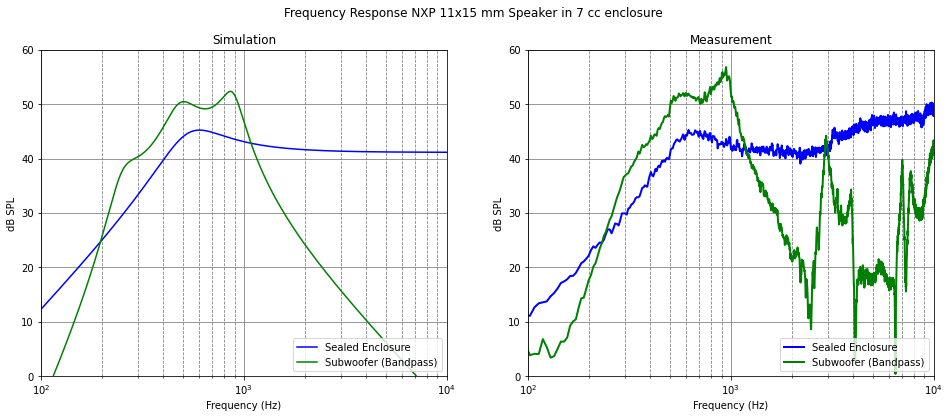

In [18]:
fig, axs = plt.subplots(1,2,figsize=(16,6))
fig.suptitle('Frequency Response NXP 11x15 mm Speaker in '+str(Vbcc)+' cc enclosure')

axs[0].semilogx(afreq,20*np.log10(abs(puclose)/0.00002),'b')
axs[0].semilogx(afreq,20*np.log10(abs(puu)/0.00002),'g')


axs[0].grid(b=True, which='major', color='grey', linestyle='-')
axs[0].grid(b=True, which='minor', color='grey', linestyle='--')
axs[0].set_xlim(100,10000)
axs[0].set_ylim(0,60)
axs[0].set_xlabel('Frequency (Hz)');
axs[0].set_ylabel('dB SPL');
axs[0].legend(['Sealed Enclosure', 'Subwoofer (Bandpass)'],loc=4);
#axs[0].legend(['Subwoofer (Bandpass)',loc=4);
axs[0].set_title('Simulation');

axs[1].semilogx(spectrum_FF1[0], 10*np.log10(spectrum_FF1[1])+118  ,'b', linewidth=2)
axs[1].semilogx(spectrum_FF2[0], 10*np.log10(spectrum_FF2[1])+118, 'g', linewidth=2)

#-----------------
axs[1].grid(b=True, which='major', color='grey', linestyle='-')
axs[1].grid(b=True, which='minor', color='grey', linestyle='--')
axs[1].set_xlim(100,10000)
axs[1].set_ylim(0,60)
axs[1].set_xlabel('Frequency (Hz)');
axs[1].set_ylabel('dB SPL');
axs[1].legend(['Sealed Enclosure', 'Subwoofer (Bandpass)'],loc=4);
axs[1].set_title('Measurement');

<span style="color:#4169E1">
    
- There is a bit too much damping in the front cavity port model (around 900Hz). Port "resistor" Rp must be adjusted (friction of the air moving in the tube).
- Most of the acoustic power is now concentrated in the band [350 - 1000]Hz with a significant sound level increase in [500 Hz-1000] Hz over the case: speaker in sealed enclosure. 
- Peaks in the frequency response above 2 kHz are induced by enclosures acoustic resonance and port acoustic resonances. These elements are not present in the model. If a real subwoofer was to be designed, the frequency response should be low pass filtered above 1.5 kHz (analog passive low pass filter)
- The subwoofer is an acoustic bandpass filter. 